Skip the first two steps if you've already ran them and simply need to continue downloading images

In [1]:
import math
import random
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm

import requests
import matplotlib.pyplot as plt
from io import BytesIO
import logging
import time

In [2]:
BASE_DIR = '..'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
# can try using the google downloader, in which case change this to be your google api token
ACCESS_TOKEN_DIR = os.path.join(BASE_DIR, 'google_api_key.txt')

RANDOM_SEED = 7 # for reproducibility

# each cluster must have AT LEAST this many images after doing nightlights processing
MIN_IMAGES_PER_CLUSTER = 10

In [3]:
import sys
sys.path.append(BASE_DIR)
from utils import create_space

# Generate Download Locations

In [4]:
df_eth = pd.read_csv(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'processed/clusters.csv'))

In [5]:
for country in ['ethiopia_2015']:
    os.makedirs(os.path.join(COUNTRIES_DIR, country, 'images'), exist_ok=False)

In [6]:
def generate_download_locations(df, ipc=50):
    '''
    Takes a dataframe with columns cluster_lat, cluster_lon
    Generates a 10km x 10km bounding box around the cluster and samples 
    ipc images per cluster. First samples in a grid fashion, then any 
    remaining points are randomly (uniformly) chosen
    '''
    np.random.seed(RANDOM_SEED) # for reproducability
    df_download = {'image_name': [], 'image_lat': [], 'image_lon': [], 'cluster_lat': [], 
                   'cluster_lon': [], 'cons_pc': [], 'temp': [] }
    
    # side length of square for uniform distribution
    edge_num = math.floor(math.sqrt(ipc))
    for _, r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        lats = np.linspace(min_lat, max_lat, edge_num).tolist()
        lons = np.linspace(min_lon, max_lon, edge_num).tolist()

        # performs cartesian product
        uniform_points = np.transpose([np.tile(lats, len(lons)), np.repeat(lons, len(lats))])
        
        lats = uniform_points[:,0].tolist()
        lons = uniform_points[:,1].tolist()
        
        # fills the remainder with random points
        for _ in range(ipc - edge_num * edge_num):
            lat = random.uniform(min_lat, max_lat)
            lon = random.uniform(min_lon, max_lon)
            lats.append(lat)
            lons.append(lon)
        
        # add to dict
        for lat, lon in zip(lats, lons):
            # image name is going to be image_lat_image_lon_cluster_lat_cluster_lon.png
            image_name = str(lat) + '_' + str(lon) + '_' + str(r.cluster_lat) + '_' + str(r.cluster_lon) + '.png'
            df_download['image_name'].append(image_name)
            df_download['image_lat'].append(lat)
            df_download['image_lon'].append(lon)
            df_download['cluster_lat'].append(r.cluster_lat)
            df_download['cluster_lon'].append(r.cluster_lon)
            df_download['cons_pc'].append(r.cons_pc)
            df_download['temp'].append(r.temp)
        
    return pd.DataFrame.from_dict(df_download)

In [7]:
df_eth_download = generate_download_locations(df_eth)

In [8]:
df_eth_download.shape

(26150, 7)

In [9]:
df_eth_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,temp
0,3.410784802784024_39.47107816189403_3.45570056...,3.410785,39.471078,3.455701,39.515994,14.854634,2.010416
1,3.4257567241860163_39.47107816189403_3.4557005...,3.425757,39.471078,3.455701,39.515994,14.854634,2.010416
2,3.440728645588008_39.47107816189403_3.45570056...,3.440729,39.471078,3.455701,39.515994,14.854634,2.010416
3,3.45570056699_39.47107816189403_3.45570056699_...,3.455701,39.471078,3.455701,39.515994,14.854634,2.010416
4,3.470672488391992_39.47107816189403_3.45570056...,3.470672,39.471078,3.455701,39.515994,14.854634,2.010416


In [10]:
df_eth_download['country'] = 'eth'

In [11]:
# for image download purposes the country distinction is irreleveant
df_potential_download = pd.concat([df_eth_download], axis=0)
df_potential_download.reset_index(drop=True, inplace=True)

In [12]:
df_potential_download.tail()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,temp,country
26145,14.4559615944_39.52399813830598_14.4559615944_...,14.455962,39.523998,14.455962,39.479082,11.19121,1.849306,eth
26146,14.470933515801992_39.52399813830598_14.455961...,14.470934,39.523998,14.455962,39.479082,11.19121,1.849306,eth
26147,14.485905437203984_39.52399813830598_14.455961...,14.485905,39.523998,14.455962,39.479082,11.19121,1.849306,eth
26148,14.500877358605976_39.52399813830598_14.455961...,14.500877,39.523998,14.455962,39.479082,11.19121,1.849306,eth
26149,14.478501247990376_39.49124495552428_14.455961...,14.478501,39.491245,14.455962,39.479082,11.19121,1.849306,eth


# Filter Download Choices

At this point the low nightlight clusters (0 and under 3) have 11 and 12 images respectively, meaning very few more images can be dropped without going under 10.

In [13]:
from sklearn.mixture import GaussianMixture as GMM
X = df_potential_download['temp'].values.reshape(-1,1)
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(df_potential_download['temp'].values.reshape(-1,1))

In [14]:
(labels==0).mean(), (labels==1).mean(), (labels==2).mean()

(0.19694072657743786, 0.5411089866156787, 0.26195028680688337)

In [15]:
# these are the cutoff for the labels identified by the Guassian Mixture Model
label0_max = df_potential_download['temp'][labels==0].max()
label1_max = df_potential_download['temp'][labels==1].max()
label2_max = df_potential_download['temp'][labels==2].max()

label0_max, label1_max, label2_max

(2.1138878, 2.9000015, 2.4994774)

In [16]:
# I am going to hand reassign these to have better representation among all three classes
# these are not ideal distributions obviously but the model should still be able to learn
# something like a quantile cut might work better and be less arbitrary, but for reproducability 
# purposes I'll stick to the GMM-based approach
label0_max = 2.2
label1_max = 2.6
label2_max = 3

In [17]:
def query_df(df, lower, upper):
    return df[((lower <= df['temp']) & (df['temp'] < upper))]

print(len(query_df(df_potential_download, 0, label0_max)) / len(df_potential_download))
print(len(query_df(df_potential_download, label0_max, label1_max)) / len(df_potential_download))
print(len(query_df(df_potential_download, label1_max, label2_max)) / len(df_potential_download))

0.248565965583174
0.29063097514340347
0.4608030592734226


In [18]:
def create_temp_bin(df, cutoffs):
    assert len(cutoffs) >= 2, print('need at least 2 bins')
    cutoffs = sorted(cutoffs, reverse=True)
    labels = list(range(len(cutoffs)))[::-1]
    df['temp_bin'] = len(cutoffs)
    for cutoff, label in zip(cutoffs, labels):
        df['temp_bin'].loc[df['temp'] <= cutoff] = label

df_download = df_potential_download.copy()
create_temp_bin(df_download, cutoffs=[label0_max, label1_max, label2_max])

/root/miniconda3/envs/omtest/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
# these should match above
(df_download['temp_bin']==0).mean(), (df_download['temp_bin']==1).mean(), (df_download['temp_bin']==2).mean()


(0.248565965583174, 0.29063097514340347, 0.4608030592734226)

In [20]:
df_download.shape

(26150, 9)

In [21]:
df_download.loc[df_download['temp_bin']==3]

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,temp,country,temp_bin


In [22]:
df_download.tail()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,temp,country,temp_bin
26145,14.4559615944_39.52399813830598_14.4559615944_...,14.455962,39.523998,14.455962,39.479082,11.19121,1.849306,eth,0
26146,14.470933515801992_39.52399813830598_14.455961...,14.470934,39.523998,14.455962,39.479082,11.19121,1.849306,eth,0
26147,14.485905437203984_39.52399813830598_14.455961...,14.485905,39.523998,14.455962,39.479082,11.19121,1.849306,eth,0
26148,14.500877358605976_39.52399813830598_14.455961...,14.500877,39.523998,14.455962,39.479082,11.19121,1.849306,eth,0
26149,14.478501247990376_39.49124495552428_14.455961...,14.478501,39.491245,14.455962,39.479082,11.19121,1.849306,eth,0


In [23]:
os.makedirs(PROCESSED_DIR, exist_ok=True)

In [24]:
df_download.to_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'), index=False)

# Download Images
If the script breaks, you can restart here by uncommenting the line below and running the below code again. It won't download images you have already downloaded.

In [25]:
df_download = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'))

In [26]:
df_download.loc[df_download['image_lat'] == 14.196963415201992]

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,temp,country,temp_bin
25604,14.196963415201992_36.43507732509403_14.181991...,14.196963,36.435077,14.181991,36.479993,12.240846,1.888195,eth,0
25611,14.196963415201992_36.45004924649602_14.181991...,14.196963,36.450049,14.181991,36.479993,12.240846,1.888195,eth,0
25618,14.196963415201992_36.46502116789801_14.181991...,14.196963,36.465021,14.181991,36.479993,12.240846,1.888195,eth,0
25625,14.196963415201992_36.4799930893_14.1819914938...,14.196963,36.479993,14.181991,36.479993,12.240846,1.888195,eth,0
25632,14.196963415201992_36.494965010701996_14.18199...,14.196963,36.494965,14.181991,36.479993,12.240846,1.888195,eth,0
25639,14.196963415201992_36.50993693210398_14.181991...,14.196963,36.509937,14.181991,36.479993,12.240846,1.888195,eth,0
25646,14.196963415201992_36.52490885350598_14.181991...,14.196963,36.524909,14.181991,36.479993,12.240846,1.888195,eth,0


In [27]:
# you can try the google downloader if you don't have the planet API key
# the tradeoff is that planet's data can be queried with time, but Google's images
# are higher res
from utils import GoogleDownloader

In [28]:
# you can try the google downloader if you don't have the planet API key
# the tradeoff is that planet's data can be queried with time, but Google's images
# are higher res
from utils import GoogleDownloader

class GoogleDownloader:
    def __init__(self, access_token):
        self.access_token = access_token
        self.url = 'https://maps.googleapis.com/maps/api/staticmap?center={},{}&zoom={}&size=400x400&maptype=satellite&key={}'
    
    def download(self, lat, long, zoom):
        res = requests.get(self.url.format(lat, long, zoom, self.access_token))
        # server needs to make image available, takes a few seconds
        if res.status_code == 403:
            return 'RETRY'
        assert res.status_code < 400, print(f'Error - failed to download {lat}, {long}, {zoom}')
        image = plt.imread(BytesIO(res.content))
        return image

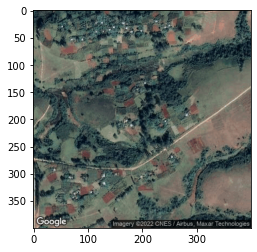

In [29]:
# this demonstrates the API call
lat = 9.43017369454541
lon = 35.598250977251546
min_year = 2016
min_month = 1
max_year = 2016
max_month = 12

access = open(ACCESS_TOKEN_DIR, 'r').readlines()[0].strip()
pd = GoogleDownloader(access)
plt.imshow(pd.download(lat, lon, 16))

In [30]:
def download_images(df):
    """
    Download images using a pandas DataFrame that has "image_lat", "image_lon", "image_name", "country" as columns
    
    Saves images to the corresponding country's images folder

    To use the Google Downloader, switch PlanetDownloader to GoogleDownloader and make imd.download_image only
    provide lat and lon as arguments. Use zoom = 16.
    """
    access = None
    with open(ACCESS_TOKEN_DIR, 'r') as f:
        access = f.readlines()[0]
    imd = GoogleDownloader(access)
    num_retries = 1
    wait_time = 0.1 # seconds

    # drops what is already downloaded
    already_downloaded = os.listdir(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'images'))
    already_downloaded = list(set(already_downloaded).intersection(set(df['image_name'])))
    print('Already downloaded ' + str(len(already_downloaded)))
    df = df.set_index('image_name').drop(already_downloaded).reset_index()
    print('Need to download ' + str(len(df)))
    # use three years of images to find one that matches search critera
    min_year = 2014
    min_month = 1
    max_year = 2016
    max_month = 12
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        lat = r.image_lat
        lon = r.image_lon
        name = r.image_name
        country_dir = None
        if r.country == 'eth':
            country_dir = 'ethiopia_2015'
        elif r.country =='mw':
            country_dir = 'malawi_2016'
        elif r.country == 'ng':
            country_dir = 'nigeria_2015'
        else:
            print(f"unrecognized country: {r.country}")
            raise ValueError()
        image_save_path = os.path.join(COUNTRIES_DIR, country_dir, 'images', r.image_name)
        try:
            im = imd.download(lat, lon, 16)
            if (type(im) == str and im == 'RETRY') or im is None:
                resolved = False
                for _ in range(num_retries):
                    time.sleep(wait_time)
                    im = imd.download(lat, lon, 16)
                    if (type(im) == str and im == 'RETRY') or im is None:
                        continue
                    else:
                        plt.imsave(image_save_path, im)
                        resolved = True
                        break
                if not resolved:
                    print(f'Could not download {lat}, {lon} despite several retries and waiting')
                    continue
                else:
                    pass
            else:
                # no issues, save according to naming convention
                plt.imsave(image_save_path, im)

        except Exception as e:
            logging.error(f"Error-could not download {lat}, {lon}", exc_info=True)
            continue

In [32]:
download_images(df_download)

Already downloaded 24912
Need to download 1238


  0%|          | 0/1238 [00:00<?, ?it/s]

Could not download 7.000866022871992, 36.38060455389402 despite several retries and waiting
Could not download 8.713435558053984, 38.83538060850398 despite several retries and waiting
Could not download 13.901282616203984, 38.651662623002 despite several retries and waiting
Could not download 13.826423009194023, 38.66663454440398 despite several retries and waiting
Could not download 13.8713387734, 38.66663454440398 despite several retries and waiting
Could not download 13.8713387734, 38.68160646580598 despite several retries and waiting
Could not download 13.880415692598008, 39.74238444639403 despite several retries and waiting
Could not download 13.910359535401993, 39.74238444639403 despite several retries and waiting
Could not download 13.850471849794024, 39.75735636779602 despite several retries and waiting
Could not download 13.895387614, 39.75735636779602 despite several retries and waiting
Could not download 13.850471849794024, 39.77232828919801 despite several retries and waiti

Could not download 14.062585369498008, 38.27076184499403 despite several retries and waiting
Could not download 14.0775572909, 38.27076184499403 despite several retries and waiting
Could not download 14.092529212301992, 38.27076184499403 despite several retries and waiting
Could not download 14.107501133703984, 38.27076184499403 despite several retries and waiting
Could not download 14.122473055105976, 38.27076184499403 despite several retries and waiting
Could not download 14.032641526694023, 38.28573376639602 despite several retries and waiting
Could not download 14.047613448096016, 38.28573376639602 despite several retries and waiting
Could not download 14.062585369498008, 38.28573376639602 despite several retries and waiting
Could not download 14.0775572909, 38.28573376639602 despite several retries and waiting
Could not download 14.092529212301992, 38.28573376639602 despite several retries and waiting
Could not download 14.107501133703984, 38.28573376639602 despite several retries

Could not download 14.041061556394023, 39.02042347860598 despite several retries and waiting
Could not download 14.056033477796015, 39.02042347860598 despite several retries and waiting
Could not download 14.071005399198008, 39.02042347860598 despite several retries and waiting
Could not download 14.0859773206, 39.02042347860598 despite several retries and waiting
Could not download 14.100949242001992, 39.02042347860598 despite several retries and waiting
Could not download 14.115921163403984, 39.02042347860598 despite several retries and waiting
Could not download 14.130893084805976, 39.02042347860598 despite several retries and waiting
Could not download 14.04962245831527, 38.97231857541412 despite several retries and waiting
Could not download 14.041360257994024, 37.938270780294026 despite several retries and waiting
Could not download 14.056332179396016, 37.938270780294026 despite several retries and waiting
Could not download 14.071304100798008, 37.938270780294026 despite several 

Could not download 14.102206987801992, 37.51649830520199 despite several retries and waiting
Could not download 14.117178909203984, 37.51649830520199 despite several retries and waiting
Could not download 14.132150830605976, 37.51649830520199 despite several retries and waiting
Could not download 14.042319302194024, 37.53147022660398 despite several retries and waiting
Could not download 14.057291223596016, 37.53147022660398 despite several retries and waiting
Could not download 14.072263144998008, 37.53147022660398 despite several retries and waiting
Could not download 14.0872350664, 37.53147022660398 despite several retries and waiting
Could not download 14.102206987801992, 37.53147022660398 despite several retries and waiting
Could not download 14.117178909203984, 37.53147022660398 despite several retries and waiting
Could not download 14.132150830605976, 37.53147022660398 despite several retries and waiting
Could not download 14.042319302194024, 37.54644214800597 despite several re

Could not download 14.070651711396016, 38.2661417342 despite several retries and waiting
Could not download 14.085623632798008, 38.2661417342 despite several retries and waiting
Could not download 14.1005955542, 38.2661417342 despite several retries and waiting
Could not download 14.115567475601992, 38.2661417342 despite several retries and waiting
Could not download 14.130539397003984, 38.2661417342 despite several retries and waiting
Could not download 14.145511318405976, 38.2661417342 despite several retries and waiting
Could not download 14.055679789994024, 38.28111365560199 despite several retries and waiting
Could not download 14.070651711396016, 38.28111365560199 despite several retries and waiting
Could not download 14.085623632798008, 38.28111365560199 despite several retries and waiting
Could not download 14.1005955542, 38.28111365560199 despite several retries and waiting
Could not download 14.115567475601992, 38.28111365560199 despite several retries and waiting
Could not d

Could not download 14.157746794103984, 38.69207570399602 despite several retries and waiting
Could not download 14.172718715505976, 38.69207570399602 despite several retries and waiting
Could not download 14.082887187094023, 38.707047625398005 despite several retries and waiting
Could not download 14.097859108496015, 38.707047625398005 despite several retries and waiting
Could not download 14.112831029898008, 38.707047625398005 despite several retries and waiting
Could not download 14.1278029513, 38.707047625398005 despite several retries and waiting
Could not download 14.142774872701992, 38.707047625398005 despite several retries and waiting
Could not download 14.157746794103984, 38.707047625398005 despite several retries and waiting
Could not download 14.172718715505976, 38.707047625398005 despite several retries and waiting
Could not download 14.082887187094023, 38.7220195468 despite several retries and waiting
Could not download 14.097859108496015, 38.7220195468 despite several ret

Could not download 14.139405185898008, 38.654964902694026 despite several retries and waiting
Could not download 14.1543771073, 38.654964902694026 despite several retries and waiting
Could not download 14.169349028701992, 38.654964902694026 despite several retries and waiting
Could not download 14.184320950103984, 38.654964902694026 despite several retries and waiting
Could not download 14.199292871505977, 38.654964902694026 despite several retries and waiting
Could not download 14.109461343094024, 38.66993682409602 despite several retries and waiting
Could not download 14.124433264496016, 38.66993682409602 despite several retries and waiting
Could not download 14.139405185898008, 38.66993682409602 despite several retries and waiting
Could not download 14.1543771073, 38.66993682409602 despite several retries and waiting
Could not download 14.169349028701992, 38.66993682409602 despite several retries and waiting
Could not download 14.184320950103984, 38.66993682409602 despite several re

Could not download 14.111363705694025, 38.944681217205975 despite several retries and waiting
Could not download 14.126335627096015, 38.944681217205975 despite several retries and waiting
Could not download 14.141307548498007, 38.944681217205975 despite several retries and waiting
Could not download 14.1562794699, 38.944681217205975 despite several retries and waiting
Could not download 14.171251391301992, 38.944681217205975 despite several retries and waiting
Could not download 14.186223312703984, 38.944681217205975 despite several retries and waiting
Could not download 14.201195234105976, 38.944681217205975 despite several retries and waiting
Could not download 14.154959355963648, 38.858319599992925 despite several retries and waiting
Could not download 14.113440879594023, 39.18093168329403 despite several retries and waiting
Could not download 14.128412800996015, 39.18093168329403 despite several retries and waiting
Could not download 14.143384722398007, 39.18093168329403 despite se

Could not download 14.196963415201992, 36.494965010702 despite several retries and waiting
Could not download 14.211935336603984, 36.494965010702 despite several retries and waiting
Could not download 14.226907258005976, 36.494965010702 despite several retries and waiting
Could not download 14.137075729594024, 36.50993693210398 despite several retries and waiting
Could not download 14.152047650996016, 36.50993693210398 despite several retries and waiting
Could not download 14.167019572398008, 36.50993693210398 despite several retries and waiting
Could not download 14.1819914938, 36.50993693210398 despite several retries and waiting
Could not download 14.196963415201992, 36.50993693210398 despite several retries and waiting
Could not download 14.211935336603984, 36.50993693210398 despite several retries and waiting
Could not download 14.226907258005976, 36.50993693210398 despite several retries and waiting
Could not download 14.137075729594024, 36.52490885350598 despite several retries 

Could not download 14.207790761194024, 39.6508902034 despite several retries and waiting
Could not download 14.222762682596017, 39.6508902034 despite several retries and waiting
Could not download 14.237734603998009, 39.6508902034 despite several retries and waiting
Could not download 14.2527065254, 39.6508902034 despite several retries and waiting
Could not download 14.267678446801993, 39.6508902034 despite several retries and waiting
Could not download 14.282650368203983, 39.6508902034 despite several retries and waiting
Could not download 14.297622289605975, 39.6508902034 despite several retries and waiting
Could not download 14.207790761194024, 39.665862124802 despite several retries and waiting
Could not download 14.222762682596017, 39.665862124802 despite several retries and waiting
Could not download 14.237734603998009, 39.665862124802 despite several retries and waiting
Could not download 14.2527065254, 39.665862124802 despite several retries and waiting
Could not download 14.2

KeyboardInterrupt: 